In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json
import networkx as nx
import pulp

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

Text(0.5, 1.0, 'Population of North Carl, N=1000')

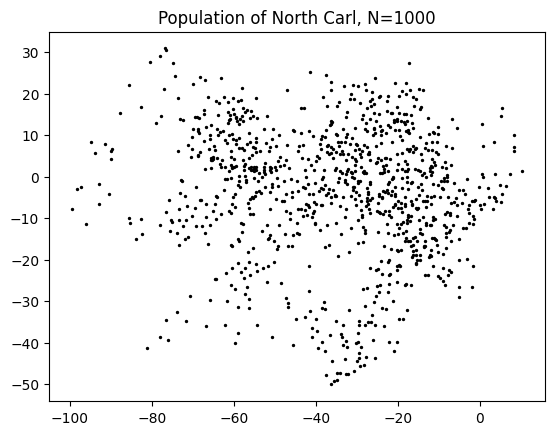

In [3]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [4]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost

In [5]:
R_antennas = 25

## Generating K-Means lattice

In [6]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [7]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of North Carl, N=1000')

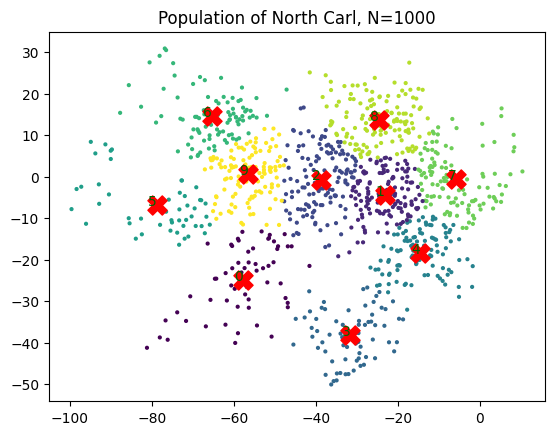

In [8]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [9]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[-57.86942197 -24.90144974]
 [-23.24122028  -4.54139396]
 [-38.80742274  -0.70521686]
 [-31.58680623 -38.2199941 ]
 [-14.59598382 -18.39971709]
 [-78.87047465  -6.93769539]
 [-65.36580745  14.63234803]
 [ -5.77987343  -0.58662834]
 [-24.63557983  13.61542382]
 [-56.53767264   0.51199519]]


## Generating Graph of the problem

In [10]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

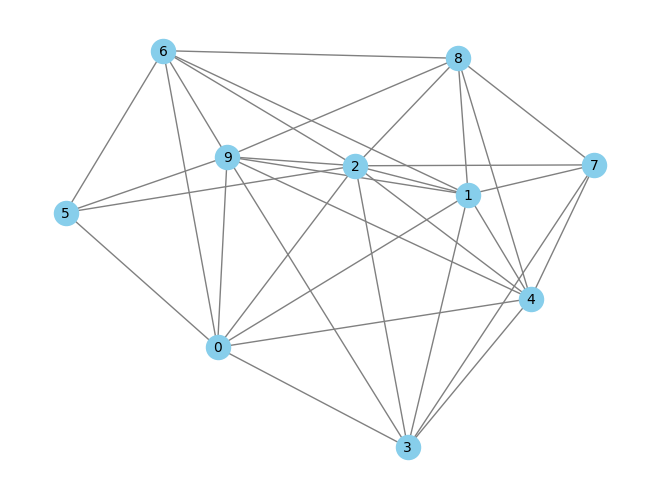

In [11]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [19]:
pdist([G.nodes.data()[5]['pos'],G.nodes.data()[8]['pos']])

array([57.99874589])

Checking the coverage if we place antennas at 10 positions (without finding MIS or MWIS)

In [12]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


finding maximum independent set and then finding coverage

In [13]:
ind_set = nx.approximation.maximum_independent_set(G)
#ind_set.add(8)
print("Heuristic solution: ", ind_set)
#ind_set.add(8)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {3, 6}
Heuristic bitstring:  0001001000
Coverage of MIS antennas 352


finding maximum weighted independent set and then coverage

In [21]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
print('Coverage of MWIS antennas', evaluate_coverage(data,placement,R_dist=25))

Maximum Weighted Independent Set: [7, 9]
Heuristic bitstring:  0000000101
Coverage of MWIS antennas 768


## Bradleymouth

Text(0.5, 1.0, 'Population of Bradleymouth, N=1000')

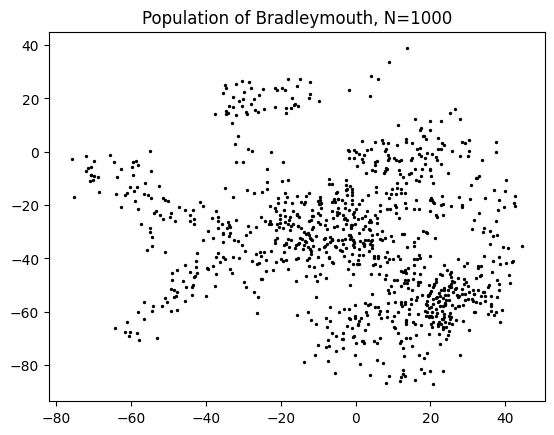

In [14]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [15]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Bradleymouth, N=1000')

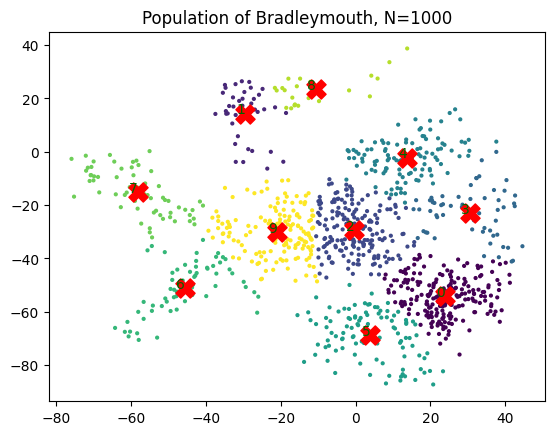

In [17]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [18]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ 23.8755767  -54.10225826]
 [-29.50298451  14.2759436 ]
 [ -0.29682938 -29.26835972]
 [ 30.49447981 -22.91030997]
 [ 13.6728913   -2.24050997]
 [  3.95812194 -68.84033776]
 [-45.65430916 -51.02495987]
 [-58.19295779 -15.13145834]
 [-10.50400286  23.38901243]
 [-21.00008596 -30.05192085]]


In [19]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

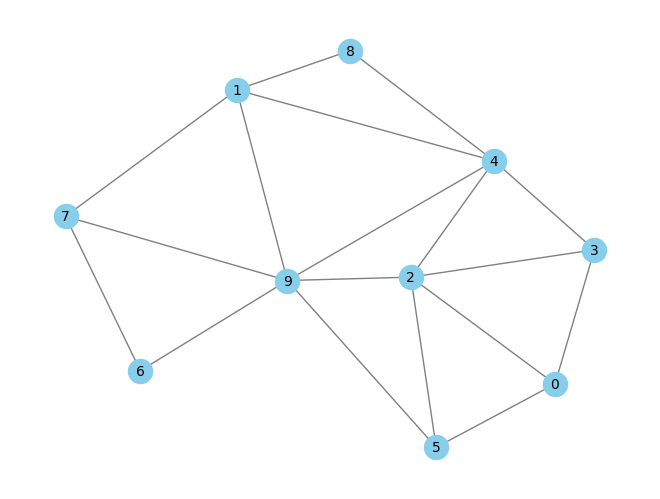

In [20]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [21]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [22]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 9, 0}
Heuristic bitstring:  1000000011
Coverage of MIS antennas 633


In [23]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
print('Coverage of MWIS antennas', evaluate_coverage(data,placement,R_dist=25))

Maximum Weighted Independent Set: [0, 8, 9]
Heuristic bitstring:  1000000011
Coverage of MWIS antennas 633


# Brandonberg

Text(0.5, 1.0, 'Population of Brandonberg, N=1000')

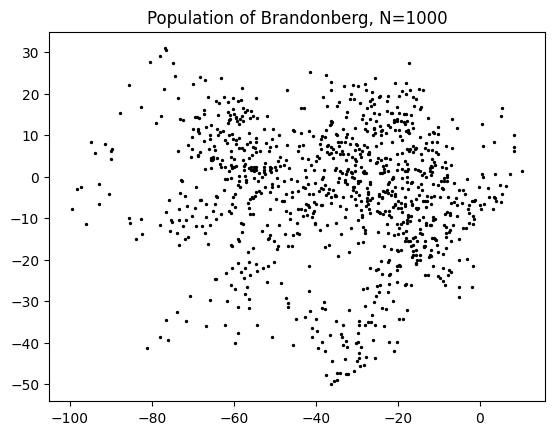

In [24]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[1]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [25]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [26]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Brandonberg, N=1000')

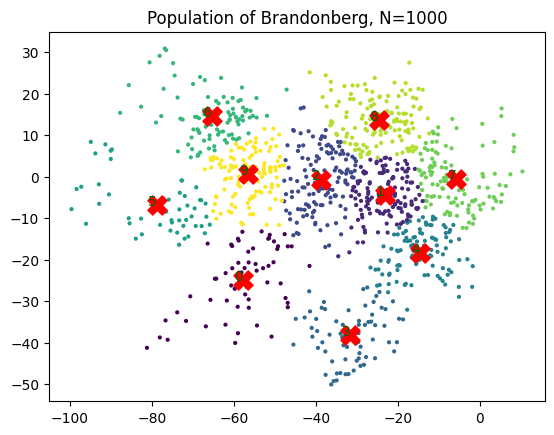

In [27]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [28]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[-57.86942197 -24.90144974]
 [-23.24122028  -4.54139396]
 [-38.80742274  -0.70521686]
 [-31.58680623 -38.2199941 ]
 [-14.59598382 -18.39971709]
 [-78.87047465  -6.93769539]
 [-65.36580745  14.63234803]
 [ -5.77987343  -0.58662834]
 [-24.63557983  13.61542382]
 [-56.53767264   0.51199519]]


In [29]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

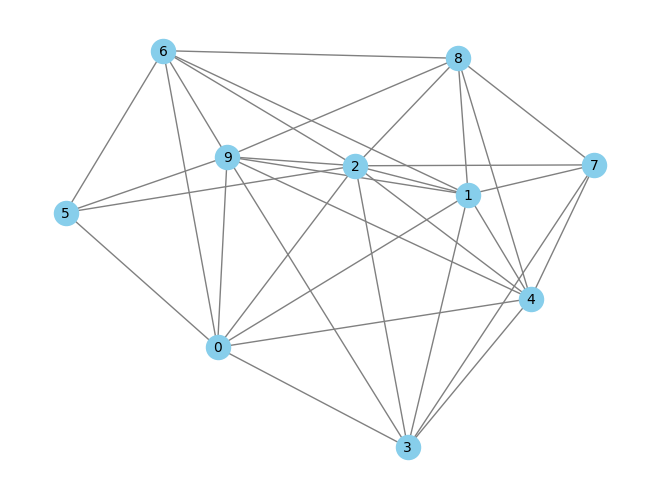

In [30]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [31]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [32]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {3, 6}
Heuristic bitstring:  0001001000
Coverage of MIS antennas 352


In [33]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
print('Coverage of MWIS antennas', evaluate_coverage(data,placement,R_dist=25))

Maximum Weighted Independent Set: [7, 9]
Heuristic bitstring:  0000000101
Coverage of MWIS antennas 768


# Hansenchester

Text(0.5, 1.0, 'Population of Hansenchester, N=1000')

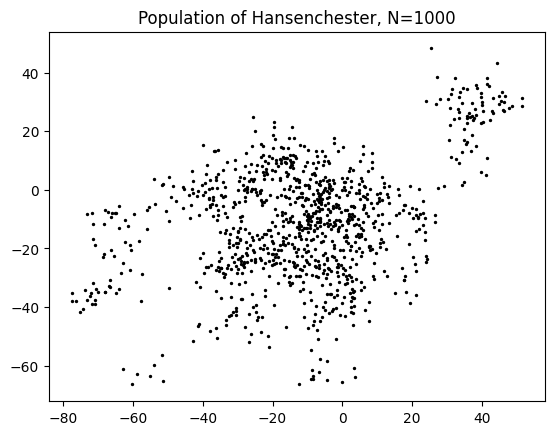

In [34]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [35]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [36]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Hansenchester, N=1000')

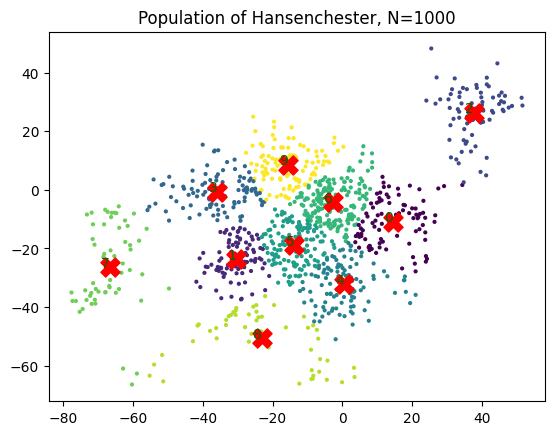

In [37]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [38]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ 14.56362541 -10.88195316]
 [-30.36708337 -23.69385194]
 [ 37.74322056  26.31502699]
 [-35.85868528  -0.6383914 ]
 [  0.55048719 -32.28745898]
 [-13.71924462 -18.87822413]
 [ -2.62157143  -4.17317993]
 [-66.71275646 -26.43263057]
 [-22.94670759 -50.72342103]
 [-15.62719058   8.60994782]]


In [39]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

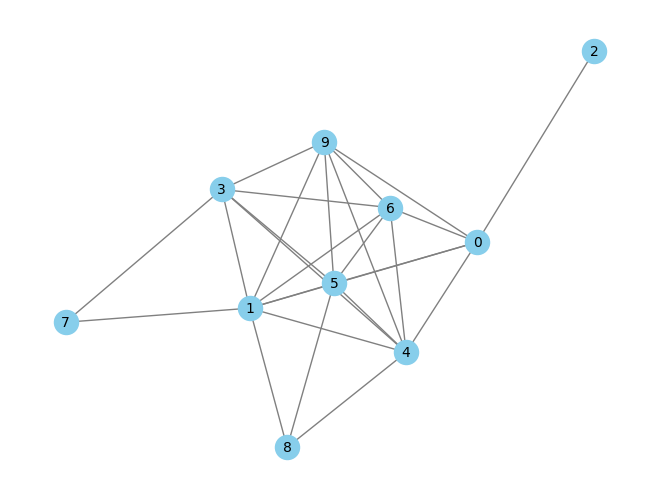

In [40]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [41]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [42]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 0, 7}
Heuristic bitstring:  1000000110
Coverage of MIS antennas 481


In [43]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [2, 6, 7, 8]
Heuristic bitstring:  0010001110
Coverage of MWIS antennas 736
Requires 4 for 73.6 coverage.


# Joshuachester

Text(0.5, 1.0, 'Population of Joshuachester, N=1000')

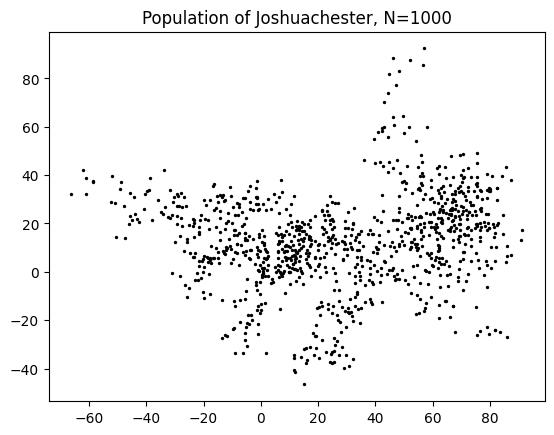

In [44]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[3]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [45]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [46]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Joshuachester, N=1000')

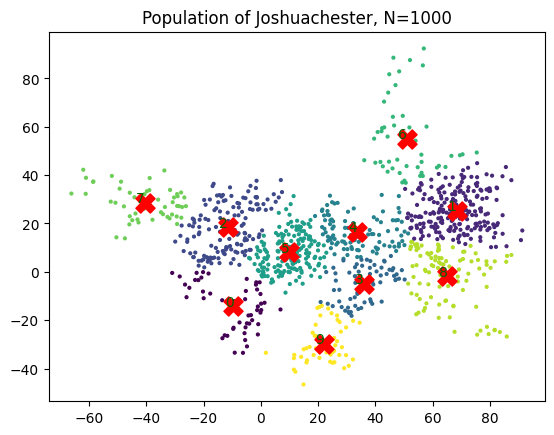

In [47]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [48]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ -9.57155488 -14.20482162]
 [ 68.33078074  25.2523093 ]
 [-11.5721596   18.40182543]
 [ 36.02624598  -4.92303104]
 [ 33.66364013  16.55284747]
 [  9.90247815   7.99857027]
 [ 50.94099226  55.04648327]
 [-40.59492049  28.67255366]
 [ 65.1476254   -1.69128507]
 [ 21.96958121 -29.68596054]]


In [49]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

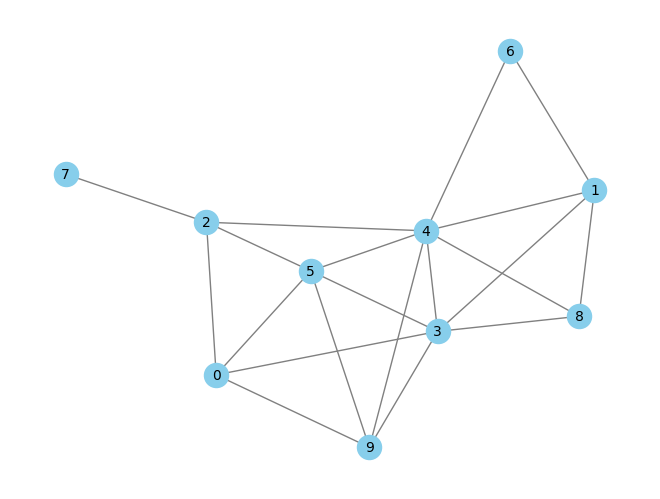

In [50]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [51]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [52]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 0, 6}
Heuristic bitstring:  1000001010
Coverage of MIS antennas 398


In [53]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [1, 5, 7]
Heuristic bitstring:  0100010100
Coverage of MWIS antennas 682
Requires 3 for 68.2 coverage.


# New Rebeccaberg

Text(0.5, 1.0, 'Population of New Rebeccaberg, N=1000')

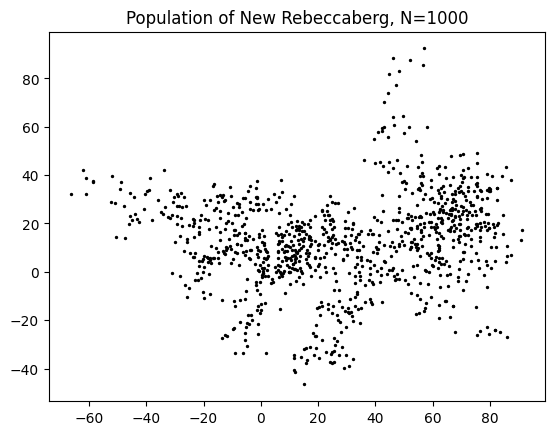

In [54]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[4]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [55]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [56]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of New Rebeccaberg, N=1000')

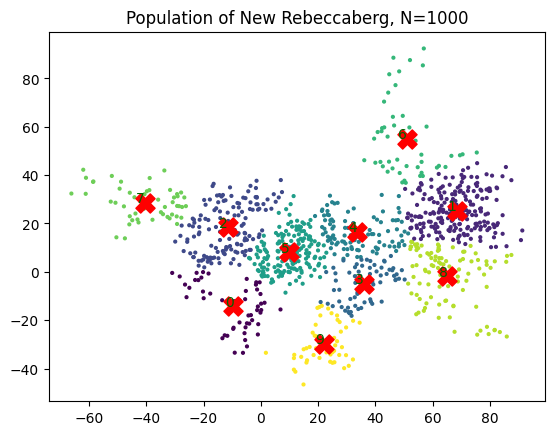

In [57]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [58]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ -9.57155488 -14.20482162]
 [ 68.33078074  25.2523093 ]
 [-11.5721596   18.40182543]
 [ 36.02624598  -4.92303104]
 [ 33.66364013  16.55284747]
 [  9.90247815   7.99857027]
 [ 50.94099226  55.04648327]
 [-40.59492049  28.67255366]
 [ 65.1476254   -1.69128507]
 [ 21.96958121 -29.68596054]]


In [59]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

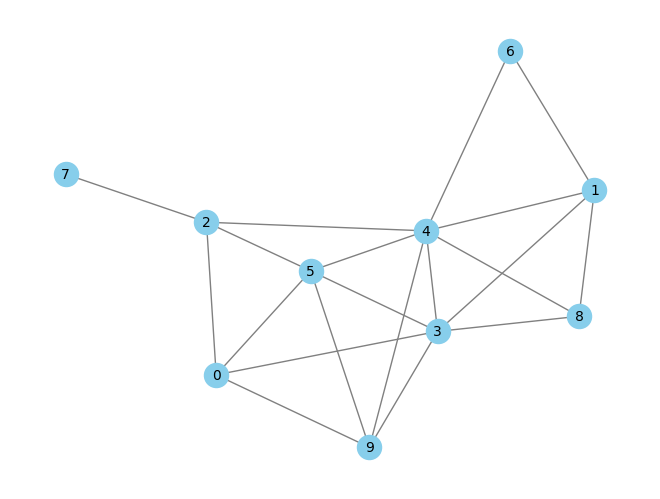

In [60]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [61]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [62]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 0, 6}
Heuristic bitstring:  1000001010
Coverage of MIS antennas 398


In [63]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [1, 5, 7]
Heuristic bitstring:  0100010100
Coverage of MWIS antennas 682
Requires 3 for 68.2 coverage.


# North Christopherbury

Text(0.5, 1.0, 'Population of North Christopherbury, N=1000')

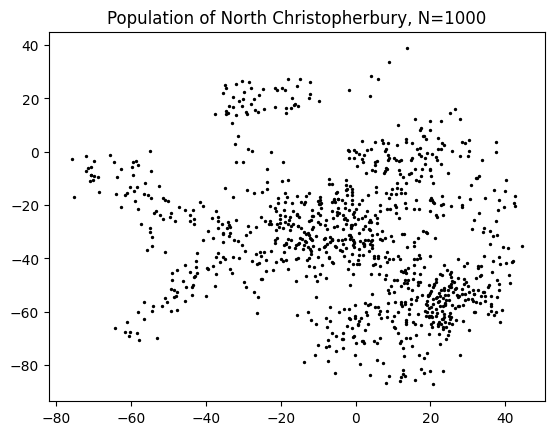

In [64]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[6]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [65]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [66]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of North Christopherbury, N=1000')

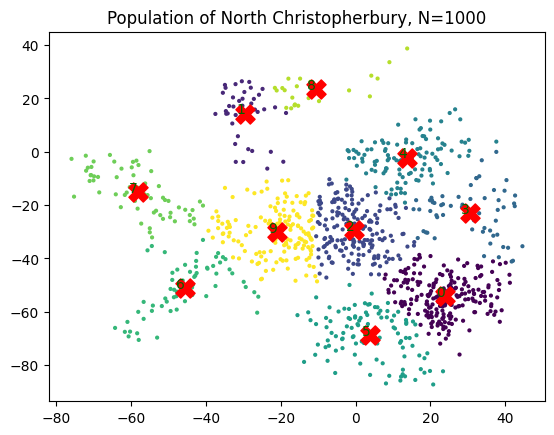

In [67]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [68]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ 23.8755767  -54.10225826]
 [-29.50298451  14.2759436 ]
 [ -0.29682938 -29.26835972]
 [ 30.49447981 -22.91030997]
 [ 13.6728913   -2.24050997]
 [  3.95812194 -68.84033776]
 [-45.65430916 -51.02495987]
 [-58.19295779 -15.13145834]
 [-10.50400286  23.38901243]
 [-21.00008596 -30.05192085]]


In [69]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

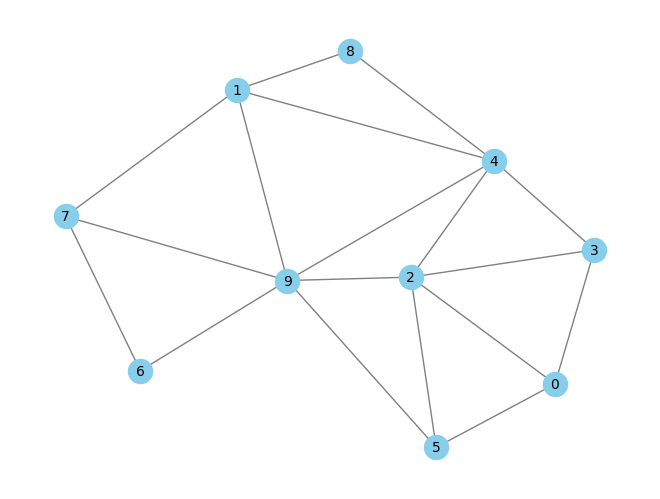

In [70]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [71]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [72]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 9, 0}
Heuristic bitstring:  1000000011
Coverage of MIS antennas 633


In [73]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [0, 8, 9]
Heuristic bitstring:  1000000011
Coverage of MWIS antennas 633
Requires 3 for 63.3 coverage.


3 antennas for 63% of population

# Port Jonathan

Text(0.5, 1.0, 'Population of Port Jonathan, N=1000')

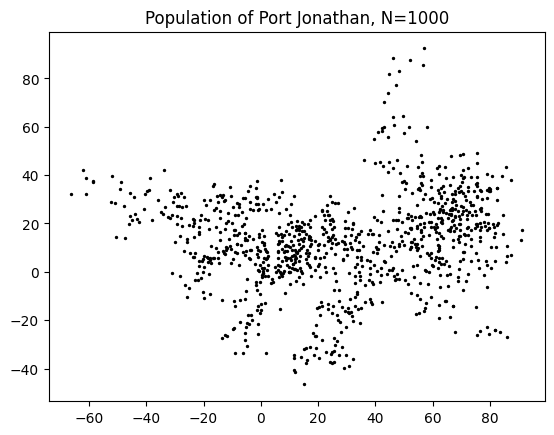

In [74]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[7]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [75]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [76]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Port Jonathan, N=1000')

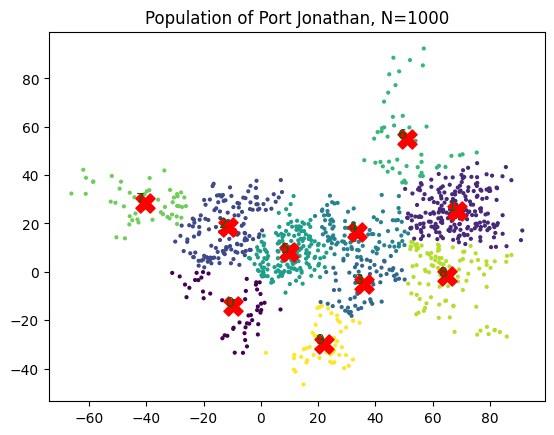

In [77]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [78]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ -9.57155488 -14.20482162]
 [ 68.33078074  25.2523093 ]
 [-11.5721596   18.40182543]
 [ 36.02624598  -4.92303104]
 [ 33.66364013  16.55284747]
 [  9.90247815   7.99857027]
 [ 50.94099226  55.04648327]
 [-40.59492049  28.67255366]
 [ 65.1476254   -1.69128507]
 [ 21.96958121 -29.68596054]]


In [79]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

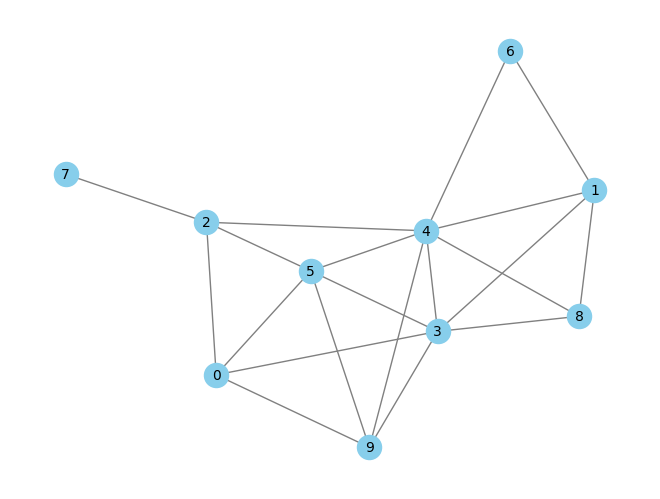

In [80]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [81]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [82]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 0, 6}
Heuristic bitstring:  1000001010
Coverage of MIS antennas 398


In [83]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [1, 5, 7]
Heuristic bitstring:  0100010100
Coverage of MWIS antennas 682
Requires 3 for 68.2 coverage.


# Zacharyburgh

Text(0.5, 1.0, 'Population of Zacharyburgh, N=1000')

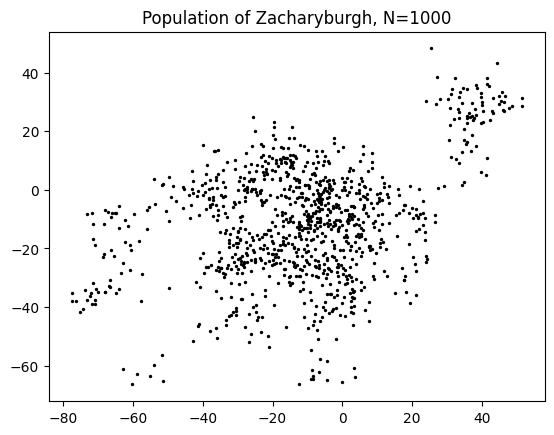

In [84]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[8]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [85]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [86]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of Zacharyburgh, N=1000')

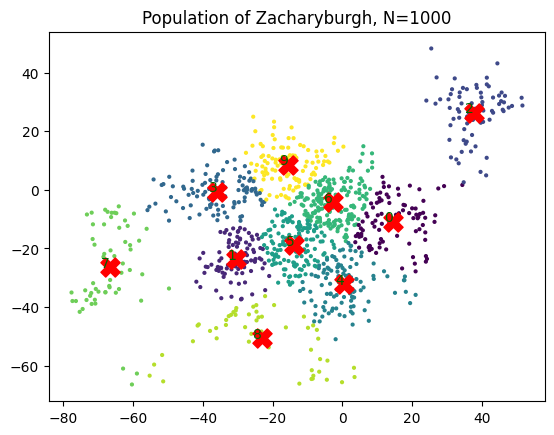

In [87]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [88]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[ 14.56362541 -10.88195316]
 [-30.36708337 -23.69385194]
 [ 37.74322056  26.31502699]
 [-35.85868528  -0.6383914 ]
 [  0.55048719 -32.28745898]
 [-13.71924462 -18.87822413]
 [ -2.62157143  -4.17317993]
 [-66.71275646 -26.43263057]
 [-22.94670759 -50.72342103]
 [-15.62719058   8.60994782]]


In [89]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

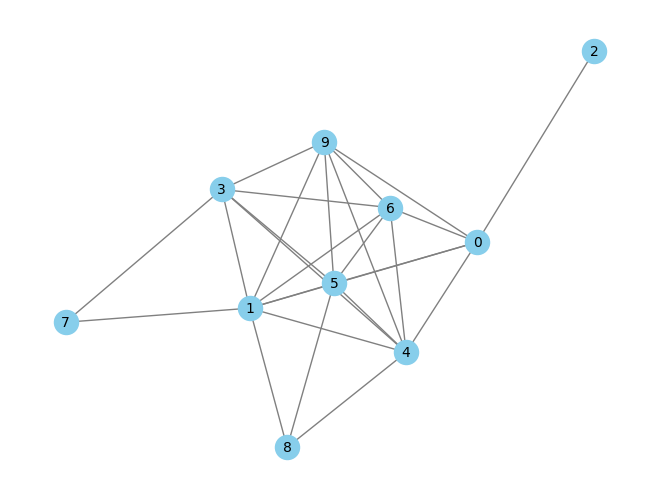

In [90]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [91]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [92]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {8, 0, 7}
Heuristic bitstring:  1000000110
Coverage of MIS antennas 481


In [93]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [2, 6, 7, 8]
Heuristic bitstring:  0010001110
Coverage of MWIS antennas 736
Requires 4 for 73.6 coverage.


# North Joshua

Text(0.5, 1.0, 'Population of North Joshua, N=1000')

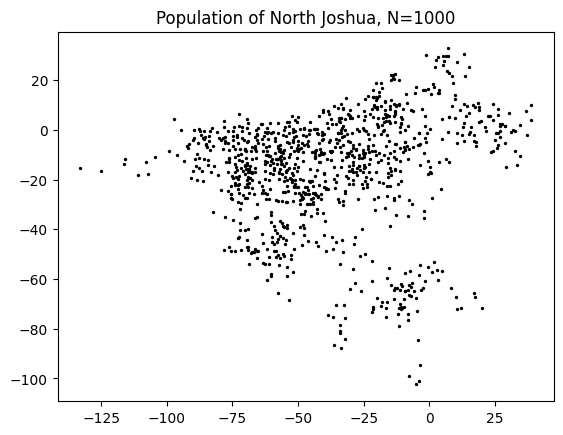

In [94]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[9]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [95]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
#population_data

In [96]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_

Text(0.5, 1.0, 'Population of North Joshua, N=1000')

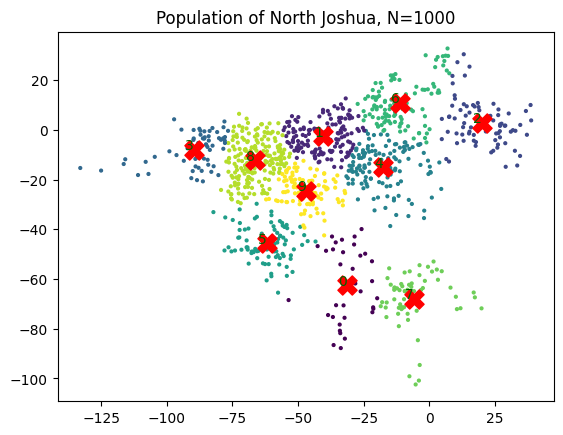

In [97]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [98]:
antenna_pos = centers.copy()
print(antenna_pos) # proposed antenna positons

[[-31.47484775 -62.52076343]
 [-40.54819475  -2.44349129]
 [ 20.05780256   2.85424279]
 [-89.57994156  -7.90963318]
 [-17.7075668  -15.10137488]
 [-61.82413998 -45.60745289]
 [-11.23438185  10.95186082]
 [ -5.92327179 -67.97503804]
 [-66.41288673 -12.05932756]
 [-47.01076624 -24.47267795]]


In [99]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

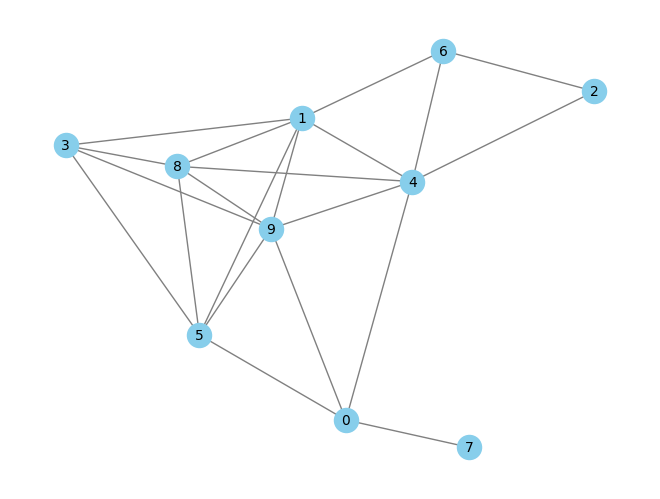

In [100]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

In [101]:
print('Coverage of 10 antennas', evaluate_coverage(data,antenna_pos,R_dist=25))

Coverage of 10 antennas -inf


In [102]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

placement = antenna_pos[list(ind_set)]

print('Coverage of MIS antennas', evaluate_coverage(data,placement,R_dist=25))

Heuristic solution:  {0, 3, 6}
Heuristic bitstring:  1001001000
Coverage of MIS antennas 436


In [103]:
# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
#print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 
placement = antenna_pos[list(independent_set)]
c=evaluate_coverage(data,placement,R_dist=25)
print('Coverage of MWIS antennas', c)
print(f'Requires {len(independent_set)} for {c/10} coverage.')

Maximum Weighted Independent Set: [0, 6, 8]
Heuristic bitstring:  1000001010
Coverage of MWIS antennas 633
Requires 3 for 63.3 coverage.
